In [0]:
#@title <b><font color="red">▶</font><font color="black"> run this cell to prepare supplementary materials for the lesson</font></b>

!rm -rf harbour-space-text-mining-course
!git clone https://github.com/horoshenkih/harbour-space-text-mining-course.git
import sys
sys.path.append('harbour-space-text-mining-course')

from tmcourse.utils import (
    enable_mathjax_in_cell,
    display_pca_scatterplot,
    display_pca_scatterplot_interactive
)
from tmcourse.demo import (
    demo_word2vec_batch,
    demo_gradient_descent,
)
from tmcourse.quiz import (
    quiz_skibidi,
    quiz_word2vec_context,
    quiz_word2vec_word_vector,
    quiz_word2vec_subsampling,
    quiz_word2vec_negative_sampling,
    quiz_most_similar,
    quiz_earl,
)
from tmcourse.ipyquiz import Quiz
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

Cloning into 'harbour-space-text-mining-course'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 454 (delta 95), reused 101 (delta 50), pack-reused 307
Receiving objects: 100% (454/454), 40.56 MiB | 20.85 MiB/s, done.
Resolving deltas: 100% (278/278), done.


<!--@slideshow slide-->
<center><h1>Word vectors</h1></center>

<!--@slideshow slide-->
# Outline
1. Sparsity problem (words are not orthogonal)
1. Word meanings and distributional hypothesis
1. word2vec: idea
1. word2vec: algorithm
1. word2vec in gensim
1. Visualization of word vectors
1. Properties of word vectors

<!--@slideshow slide-->
# Sparsity problem (words are not orthogonal)

So far, we treated words (or terms) as discrete symbols.
  - For each word, `TfidfVectorizer` creates a separate vector component.
  - Hence all words are _orthogonal_.


<!--@slideshow fragment-->
The following experiment shows that it may be a problem:
1. Take two questions from the Quora Question Pairs dataset:
    - "How can I be a good geologist?"
    - "What should I do to be a great geologist?"
1. Compute the distance between their tfidf-vectors
1. Repeat with only one change in the second question: "good" instead of "great".

In [0]:
#@slideshow slide
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
def row_to_array(sparse_matrix_row):
    return np.squeeze(np.asarray(sparse_matrix_row.todense()))

df = pd.read_csv("harbour-space-text-mining-course/datasets/quora_question_pairs/train.csv")

# words 'good' and 'great' are similar, but have different TF-IDF representations
# let's see if it makes any difference

vec = TfidfVectorizer().fit(list(df["question1"].fillna(".")) + list(df["question2"].fillna(".")))

question_1 =              "How can I be a good geologist?"  # df.iloc[7]["question1"]
question_2 =              "What should I do to be a great geologist?"  # df.iloc[7]["question2"]
question_2_reformulated = "What should I do to be a good geologist?"

vector_1 = row_to_array(vec.transform([question_1]))
vector_2 = row_to_array(vec.transform([question_2]))
vector_2_reformulated = row_to_array(vec.transform([question_2_reformulated]))
print("cosine(\"{}\", \"{}\") = {:.2f}".format(question_1, question_2, cosine(vector_1, vector_2)))
print("cosine(\"{}\", \"{}\") = {:.2f}".format(question_1, question_2_reformulated, cosine(vector_1, vector_2_reformulated)))

cosine("How can I be a good geologist?", "What should I do to be a great geologist?") = 0.24
cosine("How can I be a good geologist?", "What should I do to be a good geologist?") = 0.11


<!--@slideshow slide-->
Words "good" and "great" have similar meanings in this case, but for TF-IDF they are different.

<!--@slideshow fragment-->
**Our goal**: instead of discrete representations (all words are different, or orthogonal), find representations that captures similarity between words.


<!--@slideshow fragment-->
**Technically**, we will represent words as _vectors_ such that the words with similar meanings will have similar (close) vectors.


<!--@slideshow fragment-->
But, what is "meaning"? How do **we** understand the meaning of the word?

<!--@slideshow slide-->
# Word meanings. Distributional hypothesis.

<!--@slideshow slide-->
## Colab quiz 1
What is "skibidi"?

In [0]:
quiz_skibidi()()

<!--@slideshow fragment-->
Actually, neither the word "skibidi" nor the definitions 1-4 exist.
This quiz was generated using https://www.thisworddoesnotexist.com/

How did you know the meaning of "skibidi"?

<!--@slideshow slide-->
## Distributional semantics
**Idea**: the meaning of a word can be deduced from  _contexts_ the word appears in.

> "You shall know a word by the company it keeps" (Firth, 1957)

<!--@slideshow slide-->
- **What we need**: represent words by vectors such that words with similar meanings have similar vectors.
- **What we know (assume)**: the meaning of a word can be deduced from  _contexts_ the word appears in
- **What we will do**: given a word, predict its context.

<!--@slideshow slide-->
# word2vec


<!--@slideshow slide-->
**Idea**: for each word, find a vector such that words with similar vectors often occur in the same context.


<!--@slideshow fragment-->
- A large corpus of text (Wikipedia).
- Every word is represented by a vector.
- For each position in the text:
  1. Get the word on this position.
  1. Get the context of the word.
  1. Adjust vectors to maximize the probability of the observed context (the closer the vectors, the larger the probability).

<!--@slideshow slide-->
## Colab demo: word2vec context

By definition, the context consists of $m$ surrounding words on the left and $m$ on the right. See the demonstration for $m=3$.

In [0]:
demo_word2vec_batch("never gonna give you up never gonna let you down".split(), 3)

<!--@slideshow slide-->
## Colab quiz 2
Choose the correct context

In [0]:
quiz_word2vec_context()()

<!--@slideshow slide-->
## word2vec: objective function

Consider the position $t$ in the text:
- Word: $w_t$
- Context: $$w_{t-m}, w_{t-m + 1}, \dots, w_{\color{red}{t-1}}, w_{\color{red}{t+1}}, \dots, w_{t+m-1}, w_{t+m}$$
- Probability of the context
$$
\Pr(w_{t-m}, w_{t-m + 1}, \dots, w_{t-1}, w_{t+1}, \dots, w_{t+m-1}, w_{t+m}|w_t) \equiv \Pr_{\textrm{context}}(t)
$$
- Likelihood of the corpus is:
$$
\prod_{t=1}^T \Pr_{\textrm{context}}(t)
$$

<!--@slideshow slide-->

Word vectors are _parameters_ $\theta$.

**Our goal**: maximize the likelihood, or minimize the _negative log-likelihood_ w.r.t. $\theta$:
$$
L(\theta) = -\sum_{t=1}^T \log\Pr_{\textrm{context}}(t)
$$

<!--@slideshow fragment-->
**Assumption**: for each $t$, words both inside and outside the context are conditionally independent given $w_t$.

> Informally, for any word $\hat{w}$, the probability to find $\hat{w}$ in the context of $w_t$ depends only on $w_t$.


<!--@slideshow fragment-->
So we can write:
$$
\Pr_{\textrm{context}}(t) = \left(\prod_{w' \in \textrm{context}(w_t)} \Pr(w'|w_t)\right)\left(\prod_{w'' \notin \textrm{context}(w_t)}(1 - \Pr(w''|w))\right)
$$

<!--@slideshow slide-->
The objective function:
$$
L(\theta) = -\sum_{t=1}^T \left(\sum_{w' \in \textrm{context}(w_t)} \log\Pr(w'|w_t) + \sum_{w'' \notin \textrm{context}(w_t)}\log(1 - \Pr(w''|w))\right)
$$

As usual, we will use gradient descent to find parameters (word vectors) $\theta$ that minimize $L(\theta)$. 

<!--@slideshow slide-->
## Colab demo: gradient descent

In [0]:
demo_gradient_descent(lambda x: x**4 - x**3 - x**2 + 1, theta_0=-1, learning_rate=0.5)  # local minima
# demo_gradient_descent(lambda x: x**2, theta_0=-1, learning_rate=1.1)  # divergence

<!--@slideshow slide-->
## Problem 1: word in its own context

How do we estimate $\Pr(o|c)$?

Suppose the word $o$ has vector $\mathbf{u}$, and the word $c$ has vector $\mathbf{v}$.

It's natural to estimate
$$
\Pr(o|c) = \sigma(\mathbf{u} \cdot \mathbf{v})
$$
where $\mathbf{u} \cdot \mathbf{v}$ is the dot product, and $\sigma(s) = \dfrac{1}{1 + e^{-s}}$ is the sigmoid function.

<!--@slideshow fragment-->
But what if $o = c$?

The dot product is large, but the probability to see the word in its own context is low!

<!--@slideshow fragment-->
**Solution**: for each word $w$, instead of _one_ vector, keep _two_ vectors:
1. When $w$ is the context word: $\mathbf{u}_w$.
1. When $w$ is the central word: $\mathbf{v}_w$.

<!--@slideshow slide-->
## Problem 2: computational complexity
Remember that the objective function is
$$
L(\theta) = -\sum_{t=1}^T \left(\sum_{w' \in \textrm{context}(w_t)} \log\Pr(w'|w_t) + \sum_{\color{red}{w'' \notin \textrm{context}(w_t)}}\log(1 - \Pr(w''|w))\right)
$$


<!--@slideshow fragment-->
- In each term, the second sum is computed over the full vocabulary (except for the context of $w_t$).
- We need to compute it for each position $t$ in the text.


<!--@slideshow fragment-->
**Solution**: **for each context word**, keep only the fixed number (5-20) of terms in the second sum.

> This is called **negative sampling**.

<!--@slideshow slide-->
## Problem 3: "meaningless" words

Some words (like prepositions and articles in English)
- are very frequent,
- play only a technical role and therefore don't have meaning.



<!--@slideshow fragment-->
So they harm the performance of stochastic gradient descent, because
- they cause may updates because they are frequent,
- these updates are "noisy", because "technical" words don't have meaning.

<!--@slideshow fragment-->
**Solution**: throw frequent words away with some probability (the higher the frequency, the higher the probability).

> This is called **subsampling**.

<!--@slideshow slide-->
## Colab demo: word2vec implementation

In [0]:
import numpy as np
from collections import Counter
from scipy.special import softmax
from scipy.special import expit as sigmoid  # "expit" is the inverse of "logit"
from scipy.spatial.distance import cosine as cosine_distance

class Word2Vec:
    """
    This is an instructive implementation of skip-gram word2vec algorithm with negative sampling loss.
    It is deliberately inefficient: it uses built-in Python data structures (dicts and lists)
    instead of matrix-vector operations.

    The recommended way to read the code is the following:
    1. First, read the implementation of the `train()` method:
        - Training loop: iterate few times (epochs) over the training data.
          Number of epochs is provided in the `n_epoch` parameter,
          and `self.learning_rate` is predefined step size of gradient descent.
        - In each iteration, a batch (central_word and context_words) is generated.
        - Too frequent words are discarded (subsampling).
        - The gradients are computed and gradient step is performed.
    2. Then look at the method `generate_batches()`.
       It creates pairs (central word, [list of context words])
       by moving sliding window of predefined size `self.window_size`.
    3. Then check the `generate_negative_samples()` method.
       Its implementation is short, but there are two important details:
       - Sampling is performed with replacement. It mimics i.i.d. assumption:
         negative samples must be independent.
       - The central word and the context word are discarded from the set 
         of negative samples.
    4. The most important part is how gradients are computed: the method `compute_gradients()`.
       The gradients are derived in this lecture; this method just implements them in Python code.
    5. Then take a look at `build_vocabulary()`: it is mostly technical.
    6. `get_vector()` method is just a one-liner, but pay attention to the fact
       that we use only one of two matrices (the matrix of central vectors).
    7. `get_similar_words()` method implements inefficient (O(|V|)) search of
       words whose vectors are closest to the vector of the given word.
    8. `__init__()` method just stores all hyperparameters and initializes necessary data structures.
    """
    def __init__(
        self,
        window_size=2,
        vector_size=10,
        n_negative_samples=20,
        learning_rate=1e-5,
        seed=0
    ):
        self.window_size = window_size
        self.learning_rate = learning_rate

        self.vocab = Counter()

        # how many dimensions each vector has
        self.vector_size = vector_size
        # vectors are initialized in .build_vocabulary() after the vocabulary is known
        self.central_vectors = dict()  
        self.context_vectors = dict()

        # number of negative samples for each context word
        self.n_negative_samples = n_negative_samples

        # prepare vocabulary for negative sampling and sumsampling
        self.words_array = []
        self.negative_sampling_probabilities = []
        self.subsampling_probabilities = dict()

        np.random.seed(seed)

    def build_vocabulary(self, sequences):
        # count all the words
        for sequence in sequences:
            for word in sequence:
                self.vocab[word] += 1

        sum_counts_negative_sampling = sum(v**0.75 for v in self.vocab.values())
        sum_counts_subsampling = sum(self.vocab.values())
        for word, count in self.vocab.items():
            self.words_array.append(word)
            self.negative_sampling_probabilities.append(count**0.75 / sum_counts_negative_sampling)
            word_frequency = count / sum_counts_subsampling
            self.subsampling_probabilities[word] = (1 + np.sqrt(word_frequency / 0.001)) * 0.001 / word_frequency

        # initialize vectors with small values around 0
        for word in self.vocab:
            self.central_vectors[word] = np.random.randn(self.vector_size) * 0.1
            self.context_vectors[word] = np.random.randn(self.vector_size) * 0.1

    def generate_batches(self, sequence):
        # move sliding window over the sequence 
        # for each position of the window generate list of context words
        # return list of lists pairs (central word, [context words])
        batches = []
        for i_central, central_word in enumerate(sequence):
            # ignore the words outside of vocabulary (we don't have vectors for them)
            if central_word not in self.vocab:
                continue
            context_words = []
            # iterate from i_central - window_size, i_central + window_size
            for i_context in range(i_central - self.window_size, i_central + self.window_size + 1):
                # handle boundary cases
                if i_context < 0 or i_context >= len(sequence):
                    continue
                # exclude the central word itself
                if i_context == i_central:
                    continue
                context_word = sequence[i_context]
                # ignore the words outside of vocabulary
                if context_word not in self.vocab:
                    continue
                # update the batch that corresponds to the current central word
                context_words.append(context_word)
            # update batches with the collected batch
            batches.append((central_word, context_words))
        return batches

    def generate_negative_samples(self, central_word, context_word):
        negative_samples = np.random.choice(
            self.words_array,
            size=self.n_negative_samples,
            replace=True,  # sampling with replacement: mimics i.i.d assumption
            p=self.negative_sampling_probabilities
        )
        return [n for n in negative_samples if n != central_word and n != context_word]

    def compute_gradients(self, central_word, context_word, negative_samples):
        central_vector = self.central_vectors[central_word]

        # accumulate gradient of the central word
        central_word_gradient = np.zeros(self.vector_size)

        context_word_vector = self.context_vectors[context_word]
        context_words_gradient = -central_vector * (1 - sigmoid(np.dot(context_word_vector, central_vector)))

        central_word_gradient += -context_word_vector * (1 - sigmoid(np.dot(context_word_vector, central_vector)))

        # a word in negative sample can be sampled many times, so we accumulate gradients
        negative_samples_gradients = {n: np.zeros(self.vector_size) for n in negative_samples}
        for negative_sample in negative_samples:
            negative_sample_vector = self.context_vectors[negative_sample]
            negative_samples_gradients[negative_sample] += central_vector * (1 - sigmoid(-np.dot(negative_sample_vector, central_vector)))
            central_word_gradient += negative_sample_vector * (1 - sigmoid(-np.dot(negative_sample_vector, central_vector)))

        return central_word_gradient, context_words_gradient, negative_samples_gradients

    def train(self, sequences, n_epoch=5):
        T = 0
        for epoch in range(n_epoch):
            for sequence in sequences:
                # learning rate decays proportional to the number of iterations
                # similar to the original word2vec code
                alpha = self.learning_rate * max(0.0001, (1 - T / (n_epoch * len(sequences))))
                T += 1
                for batch in self.generate_batches(sequence):
                    central_word, context_words = batch

                    # subsample: randomly discard too frequent words
                    if np.random.random() > self.subsampling_probabilities[central_word]:
                        continue

                    for context_word in context_words:
                        # generate negative samples
                        # negative samples do not include the central word and the context word
                        negative_samples = self.generate_negative_samples(central_word, context_word)

                        # compute gradients
                        central_word_gradient, context_word_gradient, negative_samples_gradients = self.compute_gradients(
                            central_word, context_word, negative_samples
                        )
                        # perform one step of gradient descent: update all the parameters in direction opposite to gradient
                        self.central_vectors[central_word] -= alpha * central_word_gradient
                        self.context_vectors[context_word] -= alpha * context_word_gradient
                        for negative_sample in negative_samples:
                            self.context_vectors[negative_sample] -= alpha * negative_samples_gradients[negative_sample]

    def get_vector(self, word):
        return self.central_vectors[word]

    def get_similar_words(self, word, k=10):
        word_vector = self.get_vector(word)
        cosine_similarities = [1 - 0.5 * cosine_distance(word_vector, self.get_vector(w)) for w in self.words_array]
        return list(
            reversed([
                (self.words_array[i], cosine_similarities[i])
                for i in np.argsort(cosine_similarities)[-k-1:-1]  # exclude the word itself
            ])
        )


In [0]:
# toy example: "A" and "B" always occur near X
# all the other words (actually, characters) from the left and from the right are random
from string import ascii_lowercase
import random
from pprint import pprint

random.seed(0)
n_examples = 1000
# generate random left and right halves
left_contexts = [random.choices(ascii_lowercase, k=5) for _ in range(n_examples)]
right_contexts = [random.choices(ascii_lowercase, k=5) for _ in range(n_examples)]

# insert "XA" and "XB" to the middle
toy_dataset = [
    l + list("XA") + r for l, r in zip(left_contexts, right_contexts)
] + [
    l + list("XB") + r for l, r in zip(left_contexts, right_contexts)
]
random.shuffle(toy_dataset)

print("A few lines of the toy dataset:")
print("\n".join(["".join(t) for t in toy_dataset[:3]]))
window_size = 1
vector_size = 2
learning_rate = 0.1
n_epoch = 5
n_negative_samples = 5
word2vec = Word2Vec(
    seed=1,
    window_size=window_size,
    vector_size=vector_size,
    learning_rate=learning_rate,
    n_negative_samples=n_negative_samples
)
word2vec.build_vocabulary(toy_dataset)
word2vec.train(toy_dataset, n_epoch=n_epoch)
print("Words most similar to 'A'")
pprint(word2vec.get_similar_words("A"))

A few lines of the toy dataset:
vohgkXAyfvap
lgenmXAfojrf
lpkohXBwinqm
Words most similar to 'A'
[('B', 0.9999876210481136),
 ('z', 0.957950766495169),
 ('a', 0.9129377419737473),
 ('k', 0.9053724127989855),
 ('i', 0.9034941870030813),
 ('b', 0.8990275152337034),
 ('n', 0.8655117493755606),
 ('g', 0.8500906263010772),
 ('t', 0.8474761246122444),
 ('m', 0.842807328160446)]


<!--@slideshow slide-->
## Colab quiz 3

How are word vectors computed?

In [0]:
quiz_word2vec_word_vector()()

<!--@slideshow slide-->
## Colab quiz 4

Which words are subsampled?

In [0]:
quiz_word2vec_subsampling()()

<!--@slideshow slide-->
## Colab quiz 5

Details of negative sampling.

In [0]:
quiz_word2vec_negative_sampling()()

<!--@slideshow slide-->
## Derivation of gradients

<!--@slideshow slide-->
## Exercise 1
Prove that $\sigma(-\mathbf{x}) = 1 - \sigma(\mathbf{x})$.

<!--@slideshow slide-->
## Exercise 2

Prove that $\dfrac{\mathrm{d}\sigma(\mathbf{x})}{\mathrm{d}\mathbf{x}} = \sigma(\mathbf{x})(1-\sigma(\mathbf{x}))$.

<!--@slideshow slide-->
## Exercise 3

Prove that for arbitrary vectors $\mathbf{x}, \mathbf{y}$
- $\dfrac{\mathrm{d}(\mathbf{x} \cdot \mathbf{y})}{\mathrm{d}\mathbf{x}} = \mathbf{y}$
- $\dfrac{\mathrm{d}(\mathbf{x} \cdot \mathbf{y})}{\mathrm{d}\mathbf{y}} = \mathbf{x}$

<!--@slideshow slide-->
### Derivation of gradient w.r.t. central word

Consider one term in the objective function:
$$
\ell(c, o, N) = -\log\Pr(o|c) - \sum_{n \in N}\log(1 - \Pr(n|c))
$$
where $c$ is the central word, $o$ is the context ("outside") word, $n \in N$ is a negative sample.

<!--@slideshow fragment-->
Since $\Pr(o|c) = \sigma(\mathbf{u}_o \cdot \mathbf{v}_c)$ and $1 - \Pr(n|c) = \sigma(-\mathbf{u}_n \cdot \mathbf{v}_c)$, we have
$$
\ell(c, o, N) = -\log\sigma(\mathbf{u}_o \cdot \mathbf{v}_c) - \sum_{n \in N}\log\sigma(-\mathbf{u}_n \cdot \mathbf{v}_c)
$$

<!--@slideshow slide-->
$$
-\dfrac{\mathrm{d}\log\sigma(\mathbf{u}_o \cdot \mathbf{v}_c)}{\mathrm{d}\mathbf{v}_c} 
$$


<!--@slideshow fragment-->
$$
= - \dfrac{1}{\sigma(\mathbf{u}_o \cdot \mathbf{v}_c)} \dfrac{\mathrm{d}\sigma(\mathbf{u}_o \cdot \mathbf{v}_c)}{\mathrm{d}\mathbf{v}_c}
$$


<!--@slideshow fragment-->
$$
= - \dfrac{1}{\sigma(\mathbf{u}_o \cdot \mathbf{v}_c)} \sigma(\mathbf{u}_o \cdot \mathbf{v}_c) (1 - \sigma(\mathbf{u}_o \cdot \mathbf{v}_c)) \dfrac{\mathrm{d} \mathbf{u}_o \cdot \mathbf{v}_c}{\mathrm{d}\mathbf{v}_c}
$$


<!--@slideshow fragment-->
$$
= - (1 - \sigma(\mathbf{u}_o \cdot \mathbf{v}_c)) \mathbf{u}_o
$$

<!--@slideshow slide-->
Similarly,

$$
\dfrac{\mathrm{d}}{\mathrm{d}\mathbf{v}_c}\left(-\sum_{n \in N}\log\sigma(-\mathbf{u}_n \cdot \mathbf{v}_c)\right)
=
\sum_{n \in N} \mathbf{u}_n(1 - \sigma(-\mathbf{u}_n\cdot \mathbf{v}_c))
$$ 

<!--@slideshow slide-->
## Exercise 4
Find derivatives $\dfrac{\mathrm{d}\ell(c, o, N)}{\mathrm{d}\mathbf{u}_o}$ and $\dfrac{\mathrm{d}\ell(c, o, N)}{\mathrm{d}\mathbf{u}_n}$.

<!--@slideshow slide-->
# Colab demo: word2vec in gensim

## How to train

In [0]:
print("Words most similar to 'A' (gensim implementation)")
from gensim.models import Word2Vec

gensim_word2vec = Word2Vec(
    sg=1,  # skip-gram
    hs=0,  # negative sampling
    size=vector_size,
    window=window_size,
    alpha=learning_rate,
    negative=n_negative_samples
)
gensim_word2vec.build_vocab(toy_dataset)
gensim_word2vec.train(toy_dataset, total_examples=len(toy_dataset), epochs=n_epoch)
pprint(gensim_word2vec.wv.most_similar("A"))

Words most similar to 'A' (gensim implementation)
[('B', 0.9986007809638977),
 ('r', 0.9088090658187866),
 ('f', 0.8830968141555786),
 ('v', 0.8664787411689758),
 ('p', 0.8410423994064331),
 ('d', 0.8304134011268616),
 ('e', 0.8158031702041626),
 ('l', 0.7807328701019287),
 ('m', 0.777729868888855),
 ('u', 0.724033534526825)]


In [0]:
# try the real dataset
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(
    subset="all",
    shuffle=True,
    random_state=1,
    remove=('headers', 'footers', 'quotes')
)

from tqdm.notebook import tqdm
import spacy

# extract tokens (lemmas) with spaCy
nlp = spacy.load("en", disable=['parser', 'ner', 'tagger'])
def tokens(s):
    return [t.lemma_ for t in nlp(s)]

texts = [tokens(text) for text in tqdm(dataset.data, desc="tokenize")]

In [0]:
# initialize, build vocabulary and train at once
gensim_word2vec = Word2Vec(
    texts,
    sg=1,  # skip-gram
    hs=0,  # negative sampling
    size=32,
    window=5,  # context is a 5-word window around the target word
    min_count=5  # ignore words that occur less than 5 times
).wv  # "wv" stands for "word vectors"

In [0]:
gensim_word2vec.most_similar("space")

[('navigation', 0.857740044593811),
 ('satellite', 0.8460273742675781),
 ('shuttle', 0.84037846326828),
 ('lunar', 0.840324342250824),
 ('exploration', 0.837765097618103),
 ('trajectory', 0.8235849142074585),
 ('constraint', 0.8180758953094482),
 ('constellation', 0.8165766596794128),
 ('SSF', 0.8120323419570923),
 ('operation', 0.8113124966621399)]

In [0]:
gensim_word2vec.most_similar("gif")

[('BMP', 0.9493519067764282),
 ('PCX', 0.9474430084228516),
 ('bmp', 0.9132444858551025),
 ('jpeg', 0.8968145847320557),
 ('TIFF', 0.8966711759567261),
 ('ascii', 0.8963527679443359),
 ('Targa', 0.8955907225608826),
 ('xbm', 0.8945857286453247),
 ('JPG', 0.893984854221344),
 ('postscript', 0.890293538570404)]

In [0]:
gensim_word2vec.most_similar("hockey")

[('baseball', 0.9565767049789429),
 ('NHL', 0.893846869468689),
 ('football', 0.8758339881896973),
 ('ESPN', 0.8689970374107361),
 ('basketball', 0.8644440174102783),
 ('player', 0.8541895151138306),
 ('team', 0.847851037979126),
 ('arena', 0.8454728126525879),
 ('league', 0.8433417677879333),
 ('playoff', 0.842491626739502)]

## Pre-trained vectors

In [0]:
import gensim.downloader as api

# list all available models
from tabulate import tabulate
from IPython.display import display, HTML
all_gensim_models = api.info()["models"]
gensim_model_description = [(m, all_gensim_models[m]["description"]) for m in all_gensim_models]
display(HTML(tabulate(gensim_model_description, headers=("model name", "description"), tablefmt="html")))

model name,description
fasttext-wiki-news-subwords-300,"1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)."
conceptnet-numberbatch-17-06-300,"ConceptNet Numberbatch consists of state-of-the-art semantic vectors (also known as word embeddings) that can be used directly as a representation of word meanings or as a starting point for further machine learning. ConceptNet Numberbatch is part of the ConceptNet open data project. ConceptNet provides lots of ways to compute with word meanings, one of which is word embeddings. ConceptNet Numberbatch is a snapshot of just the word embeddings. It is built using an ensemble that combines data from ConceptNet, word2vec, GloVe, and OpenSubtitles 2016, using a variation on retrofitting."
word2vec-ruscorpora-300,Word2vec Continuous Skipgram vectors trained on full Russian National Corpus (about 250M words). The model contains 185K words.
word2vec-google-news-300,Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).
glove-wiki-gigaword-50,"Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-wiki-gigaword-100,"Pre-trained vectors based on Wikipedia 2014 + Gigaword 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-wiki-gigaword-200,"Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-wiki-gigaword-300,"Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-twitter-25,"Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-twitter-50,"Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/)"


In [0]:
# load relatively small (128MB) model
model = api.load("glove-wiki-gigaword-100")

In [0]:
model.most_similar("hockey")

[('basketball', 0.8041675090789795),
 ('football', 0.7833694219589233),
 ('nhl', 0.7604307532310486),
 ('soccer', 0.7440757751464844),
 ('baseball', 0.7312085628509521),
 ('league', 0.7092335224151611),
 ('skating', 0.670417070388794),
 ('lacrosse', 0.6691610813140869),
 ('team', 0.6619707345962524),
 ('games', 0.6571609973907471)]

<!--@slideshow slide-->
## Colab quiz 6

What is the most similar to "twitter"?

In [0]:
quiz_most_similar()()

<!--@slideshow slide-->
# Visualization of word vectors

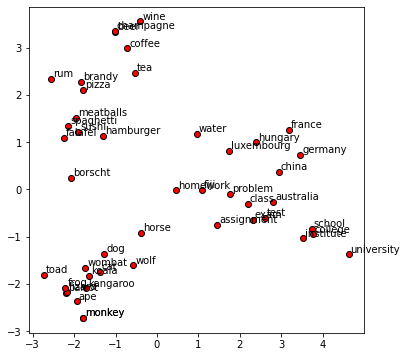

In [0]:
#@slideshow fragment tags=remove_input
display_pca_scatterplot(
    model,
    ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
    'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
    'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
    'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
    'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
    'homework', 'assignment', 'problem', 'exam', 'test', 'class',
    'school', 'college', 'university', 'institute',]
)

<!--@slideshow slide-->
# Properties of word vectors

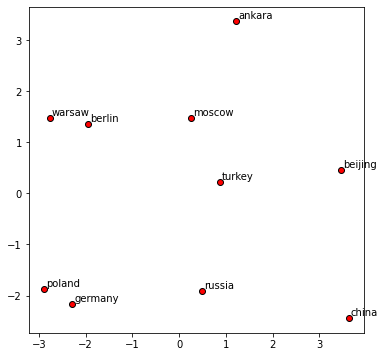

In [0]:
#@slideshow slide tags=remove_input
display_pca_scatterplot(
    model,
    [
        "china", "beijing",
        "russia", "moscow",
        "turkey", "ankara",
        "poland", "warsaw",
        "germany", "berlin",
    ]
)

<!--@slideshow fragment-->
For example, 
$$
\overrightarrow{\mathrm{Warsaw}} - \overrightarrow{\mathrm{Poland}} \approx  \overrightarrow{\mathrm{Moscow}} - \overrightarrow{\mathrm{Russia}}
$$
or, equivalently
$$
\overrightarrow{\mathrm{Warsaw}} - \overrightarrow{\mathrm{Poland}}  + \overrightarrow{\mathrm{Russia}} \approx \overrightarrow{\mathrm{Moscow}}
$$


Thus, word vectors represent some (but not all!) relations between words ("Warsaw is related to Poland the same way Moscow is related to Russia").

In [0]:
#@slideshow slide
from scipy.spatial.distance import cosine
print("Distance between <warsaw> and <moscow>:", cosine(model["warsaw"], model["moscow"]))
print("Distance between <poland> and <russia>:", cosine(model["poland"], model["russia"]))
print("Distance between <warsaw> - <poland> + <russia> and <moscow>:", cosine(model["warsaw"] - model["poland"] + model["russia"], model["moscow"]))

Distance between <warsaw> and <moscow>: 0.3461671471595764
Distance between <poland> and <russia>: 0.3346114158630371
Distance between <warsaw> - <poland> + <russia> and <moscow>: 0.13101792335510254


In [0]:
#@slideshow slide
# we can solve word analogy task with gensim
model.most_similar(positive=["poland", "moscow"], negative=["warsaw"])

[('russia', 0.8804728984832764),
 ('ukraine', 0.8040169477462769),
 ('greece', 0.7516032457351685),
 ('bulgaria', 0.7362306118011475),
 ('turkey', 0.7311098575592041),
 ('belarus', 0.7300174236297607),
 ('russian', 0.70297771692276),
 ('kazakhstan', 0.7012521624565125),
 ('armenia', 0.6977461576461792),
 ('iran', 0.6883851885795593)]

<!--@slideshow slide-->
## Colab quiz 7

In [0]:
# earl - man = X - woman
enable_mathjax_in_cell()
quiz_earl()()

<!--@slideshow slide-->
# Summary
1. Words can be represented as non-orthogonal vectors.
1. The meaning of the word can be deduced from contexts the word appears in (distributional semantics).
1. word2vec
  - Find vectors such that words with similar vectors often occur in the same context.
  - Optimize log-likelihood using gradient descent.
  - Details: 2 vectors for each word, negative sampling, subsampling.
1. word2vec in gensim.
1. Word vectors capture relations between words.

<!--@slideshow slide-->
# Recommended resources
- [📖 Distributional semantics](https://en.wikipedia.org/wiki/Distributional_semantics)
- [📖 YDSA NLP course, lecture 1](https://github.com/yandexdataschool/nlp_course/tree/2019/week01_embeddings)
- Stanford CS224n, lecture 1
  - [📺 video](https://www.youtube.com/watch?v=8rXD5-xhemo&feature=youtu.be)
  - [📖 slides](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/slides/cs224n-2019-lecture01-wordvecs1.pdf)
  - [📖 notes](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/readings/cs224n-2019-notes01-wordvecs1.pdf)
- [📖 The original word2vec code](https://code.google.com/archive/p/word2vec/)

## [OPTIONAL] Principal Component Analysis (PCA)

The illustration of the Principal Component Analysis. In case of 2 dimensions, PCA can be understood as the best projection of 2-dimensional data into a straingt line.

(-6.501071474160738, 6.877616311403685, -12.019899362227658, 10.70626356091495)

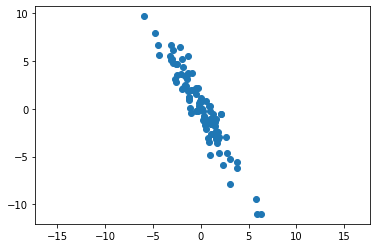

In [0]:
# project 2-dimensional ellipsoid onto a 1-dimensional line
# in other words: explain each point with a single number
def rotation_matrix(radians):
    c, s = np.cos(radians), np.sin(radians)
    return np.matrix([[c, s], [-s, c]])

def generate_cloud(size, var1, var2, radians):
    import numpy as np
    j = rotation_matrix(radians)
    return np.asarray(np.random.multivariate_normal([0., 0.], [[var1, 0], [0, var2]], size=size) @ j)

cloud = generate_cloud(100, 0.5, 20, 0.5)
import matplotlib.pyplot as plt

plt.scatter(cloud[:, 0], cloud[:, 1])
plt.axis("equal")

(-12.525150925830722, 13.84605784340887, -1.839564159481518, 1.852987588667891)

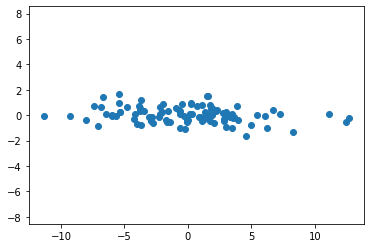

In [0]:
# find the rotation angle via slope
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(cloud[:, 0].reshape(-1, 1), cloud[:, 1])
# clf.coef_ is the slope = tan(rotation angles)
# rotate back
angle_to_rotate = -np.arctan(clf.coef_).item()
rotated_cloud = np.asarray(cloud @ rotation_matrix(angle_to_rotate))
plt.scatter(
    rotated_cloud[:, 0],  # the first principal component
    rotated_cloud[:, 1]
)
plt.axis("equal")

(-12.35373151373934,
 14.007788256632983,
 -1.6862173835975365,
 1.7064803806761488)

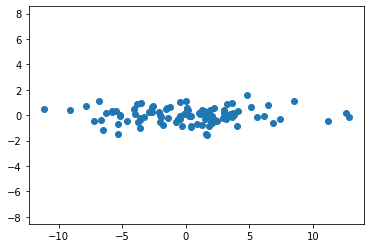

In [0]:
from sklearn.decomposition import PCA
trf = PCA()
result = trf.fit_transform(cloud)

plt.scatter(result[:, 0], result[:, 1])
plt.axis("equal")